In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [3]:
# Manage paths
%run setup_notebooks.py

In [4]:
from toolbox import wandb_export
from src import setup

In [5]:
import logging
logging.getLogger().setLevel(logging.INFO)

# Introduction

## About

Sweep: train with high number of epochs, enable early stopping with max $N_\text{stop}$ epochs of non-improving validation loss. If training stops at $N_\text{epoch}$, log the metrics at epoch $N_\text{epoch} - N_\text{stop}$ as the run summary.

This has many issues, see the slides. Here we investigate: huge overfitting of validation data and spurious performance.

## Setup

In [6]:
sweep_id = 'm41et5rs'

# Data retrieval

In [7]:
path = setup.get_local_data_path().joinpath('wandb_export_sweep_m41et5rs.csv')
raw = pd.read_csv(path)
raw.columns = map(str.lower, raw.columns)
print(raw.shape)
raw.head()

(240, 47)


,name,agent,state,notes,user,tags,created,runtime,sweep,allow_stop,...,train.recall,train.support,val.accuracy,val.epoch,val.f1-score,val.loss,val.precision,val.recall,val.support,val_loss
0,faithful-sweep-240,vprqj54b,finished,-,mazeller,NaN,2022-03-18T06:58:07.000Z,132,m41et5rs,100,...,0.900000,130,0.4375,1,0.608696,0.695688,0.4375,1.0,7,0.695688
1,dainty-sweep-239,vprqj54b,finished,-,mazeller,NaN,2022-03-18T06:55:48.000Z,134,m41et5rs,100,...,0.769231,130,0.4375,1,0.608696,0.691538,0.4375,1.0,7,0.691538
2,vibrant-sweep-238,vprqj54b,finished,-,mazeller,NaN,2022-03-18T06:53:54.000Z,112,m41et5rs,100,...,0.269231,130,0.5625,1,0.000000,0.690663,0.0000,0.0,7,0.690663
3,bright-sweep-237,vprqj54b,finished,-,mazeller,NaN,2022-03-18T06:52:00.000Z,107,m41et5rs,100,...,0.476923,130,0.5625,1,0.000000,0.708929,0.0000,0.0,7,0.708929
4,prime-sweep-236,vprqj54b,finished,-,mazeller,NaN,2022-03-18T06:49:38.000Z,136,m41et5rs,100,...,1.000000,130,0.4375,3,0.608696,0.689223,0.4375,1.0,7,0.689223


In [8]:
# Sanity check
assert raw.sweep.nunique() == 1

In [9]:
# Discard useless columns
df = raw.drop(columns=['name', 'agent', 'state', 'notes', 'user', 'tags', 'created', 'runtime', 'sweep'])
# Keep only columns with different values
mask = df.nunique() > 1
df = df[mask[mask].index]

df

,num_equiv,num_gin,num_hidden_dim,optimizer.lr,cv.fold_id,train.accuracy,train.epoch,train.f1-score,train.loss,train.precision,train.recall,train.support,val.accuracy,val.epoch,val.f1-score,val.loss,val.precision,val.recall,val.support,val_loss
0,6,1,16,0.0001,9,0.411765,1,0.565217,0.698471,0.411972,0.900000,130,0.437500,1,0.608696,0.695688,0.437500,1.000,7,0.695688
1,6,1,16,0.0020,9,0.421569,1,0.530504,0.694247,0.404858,0.769231,130,0.437500,1,0.608696,0.691538,0.437500,1.000,7,0.691538
2,6,1,8,0.0001,9,0.562092,1,0.343137,0.705715,0.472973,0.269231,130,0.562500,1,0.000000,0.690663,0.000000,0.000,7,0.690663
3,6,1,8,0.0020,9,0.480392,1,0.438163,0.707489,0.405229,0.476923,130,0.562500,1,0.000000,0.708929,0.000000,0.000,7,0.708929
4,6,0,16,0.0001,9,0.424837,3,0.596330,0.691561,0.424837,1.000000,130,0.437500,3,0.608696,0.689223,0.437500,1.000,7,0.689223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,3,1,8,0.0020,0,0.622517,56,0.592857,0.657469,0.546053,0.648438,128,0.555556,56,0.600000,0.583694,0.500000,0.750,8,0.583694
236,3,0,16,0.0001,0,0.788079,404,0.753846,0.540775,0.742424,0.765625,128,0.666667,404,0.666667,0.554184,0.600000,0.750,8,0.554184
237,3,0,16,0.0020,0,0.655629,79,0.614815,0.622864,0.584507,0.648438,128,0.722222,79,0.736842,0.494799,0.636364,0.875,8,0.494799
238,3,0,8,0.0001,0,0.543046,220,0.566038,0.676244,0.473684,0.703125,128,0.500000,220,0.470588,0.661299,0.444444,0.500,8,0.661299


In [10]:
df.nunique().sort_values()

num_gin              2
num_hidden_dim       2
optimizer.lr         2
val.support          2
train.support        2
num_equiv            3
cv.fold_id          10
val.recall          14
val.accuracy        30
val.precision       34
val.f1-score        52
train.recall        99
train.accuracy     157
train.epoch        160
val.epoch          160
train.precision    217
train.f1-score     222
train.loss         240
val.loss           240
val_loss           240
dtype: int64

In [11]:
# Sanity check
df['cv.fold_id'].value_counts()

9    24
8    24
7    24
6    24
5    24
4    24
3    24
2    24
1    24
0    24
Name: cv.fold_id, dtype: int64

There are 24 models in total that we want to aggregate on the 10 folds.

In [12]:
hyperparams = df.columns.drop(e for e in df.columns if 'val' in e or 'train' in e)
hyperparams = hyperparams.drop('cv.fold_id')
hyperparams

Index(['num_equiv', 'num_gin', 'num_hidden_dim', 'optimizer.lr'], dtype='object')

In [13]:
# Sanity check: are there all folds for each hyperparam combin ?
df.groupby(hyperparams.tolist()).val_loss.count()

num_equiv  num_gin  num_hidden_dim  optimizer.lr
3          0        8               0.0001          10
                                    0.0020          10
                    16              0.0001          10
                                    0.0020          10
           1        8               0.0001          10
                                    0.0020          10
                    16              0.0001          10
                                    0.0020          10
4          0        8               0.0001          10
                                    0.0020          10
                    16              0.0001          10
                                    0.0020          10
           1        8               0.0001          10
                                    0.0020          10
                    16              0.0001          10
                                    0.0020          10
6          0        8               0.0001          10
                

## Aggregate over folds

In [29]:
aggreg = {col: ('mean', 'std') for col in ('val.loss', 'train.loss', 'val.f1-score', 'train.f1-score', 'train.epoch')}
res = df.groupby(hyperparams.tolist()).agg(aggreg)
# Flatten hierarchical columns
cols = ['.'.join(e) for e in res.columns.to_flat_index()]
res.columns = cols
# Build mapping hyperparams -> config name
map_config = res.index

res.reset_index(inplace=True)

res

,num_equiv,num_gin,num_hidden_dim,optimizer.lr,val.loss.mean,val.loss.std,train.loss.mean,train.loss.std,val.f1-score.mean,val.f1-score.std,train.f1-score.mean,train.f1-score.std,train.epoch.mean,train.epoch.std
0,3,0,8,0.0001,0.656036,0.037060,0.653360,0.038867,0.536715,0.197533,0.605011,0.054962,281.6,279.277321
1,3,0,8,0.0020,0.597732,0.085121,0.643108,0.063002,0.632325,0.084376,0.595183,0.107046,152.4,139.268087
2,3,0,16,0.0001,0.611914,0.092485,0.624289,0.084240,0.603893,0.135489,0.654372,0.102360,245.5,251.100356
3,3,0,16,0.0020,0.575607,0.072621,0.616623,0.061689,0.649908,0.079721,0.644785,0.067493,150.9,121.428031
4,3,1,8,0.0001,0.640780,0.041073,0.643954,0.034730,0.588816,0.135342,0.611355,0.058954,342.0,269.452119
5,3,1,8,0.0020,0.596681,0.084033,0.634985,0.066834,0.677408,0.083311,0.622314,0.076294,165.5,165.836097
6,3,1,16,0.0001,0.621116,0.065460,0.617337,0.047565,0.604623,0.111884,0.662803,0.061547,214.3,159.003878
7,3,1,16,0.0020,0.622371,0.070932,0.654554,0.051217,0.560760,0.231507,0.566562,0.087358,148.8,161.534173
8,4,0,8,0.0001,0.642559,0.055149,0.646043,0.052298,0.539843,0.215008,0.576048,0.210113,271.6,265.415063
9,4,0,8,0.0020,0.565551,0.093286,0.602822,0.060823,0.695136,0.095891,0.655098,0.084006,162.8,110.500679


In [15]:
map_config_names = map_config.names
print(map_config_names)
map_config = {
    k: i for i, k in enumerate(map_config)
}
map_config

['num_equiv', 'num_gin', 'num_hidden_dim', 'optimizer.lr']


{(3, 0, 8, 0.0001): 0,
 (3, 0, 8, 0.002): 1,
 (3, 0, 16, 0.0001): 2,
 (3, 0, 16, 0.002): 3,
 (3, 1, 8, 0.0001): 4,
 (3, 1, 8, 0.002): 5,
 (3, 1, 16, 0.0001): 6,
 (3, 1, 16, 0.002): 7,
 (4, 0, 8, 0.0001): 8,
 (4, 0, 8, 0.002): 9,
 (4, 0, 16, 0.0001): 10,
 (4, 0, 16, 0.002): 11,
 (4, 1, 8, 0.0001): 12,
 (4, 1, 8, 0.002): 13,
 (4, 1, 16, 0.0001): 14,
 (4, 1, 16, 0.002): 15,
 (6, 0, 8, 0.0001): 16,
 (6, 0, 8, 0.002): 17,
 (6, 0, 16, 0.0001): 18,
 (6, 0, 16, 0.002): 19,
 (6, 1, 8, 0.0001): 20,
 (6, 1, 8, 0.002): 21,
 (6, 1, 16, 0.0001): 22,
 (6, 1, 16, 0.002): 23}

In [16]:
# Add identifier in full dataframe
df['config'] = df[map_config_names].apply(lambda e: map_config[tuple(e)], axis=1)

In [17]:
# Sanity check
assert df.config.value_counts().nunique() == 1

# Data analysis

In [18]:
res.sort_values('val.f1-score.mean', ascending=False, inplace=True)
res

,num_equiv,num_gin,num_hidden_dim,optimizer.lr,val.loss.mean,val.loss.std,train.loss.mean,train.loss.std,val.f1-score.mean,val.f1-score.std,train.f1-score.mean,train.f1-score.std
9,4,0,8,0.0020,0.565551,0.093286,0.602822,0.060823,0.695136,0.095891,0.655098,0.084006
5,3,1,8,0.0020,0.596681,0.084033,0.634985,0.066834,0.677408,0.083311,0.622314,0.076294
17,6,0,8,0.0020,0.598896,0.075245,0.644283,0.063337,0.668938,0.102024,0.594671,0.102414
3,3,0,16,0.0020,0.575607,0.072621,0.616623,0.061689,0.649908,0.079721,0.644785,0.067493
19,6,0,16,0.0020,0.616472,0.062937,0.658152,0.047857,0.641312,0.090162,0.543696,0.151522
1,3,0,8,0.0020,0.597732,0.085121,0.643108,0.063002,0.632325,0.084376,0.595183,0.107046
10,4,0,16,0.0001,0.631857,0.055376,0.631686,0.039814,0.629621,0.079452,0.654934,0.043009
11,4,0,16,0.0020,0.578554,0.084691,0.613466,0.061307,0.627291,0.198918,0.644074,0.073012
15,4,1,16,0.0020,0.617064,0.056133,0.665095,0.025418,0.622672,0.088079,0.581751,0.036784
23,6,1,16,0.0020,0.643153,0.046878,0.671963,0.019548,0.615014,0.081289,0.551104,0.045306


In [19]:
config_ordered_f1 = [
    map_config[tuple(row[map_config_names])] for _, row in res.iterrows()
]

## Overall f1 scores

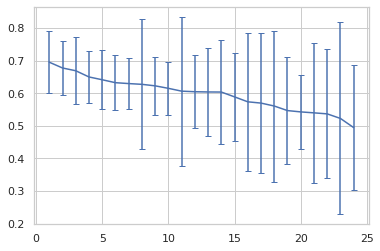

In [20]:
plt.errorbar(x=range(1, res.shape[0]+1), y=res['val.f1-score.mean'], yerr=res['val.f1-score.std'], capsize=3);

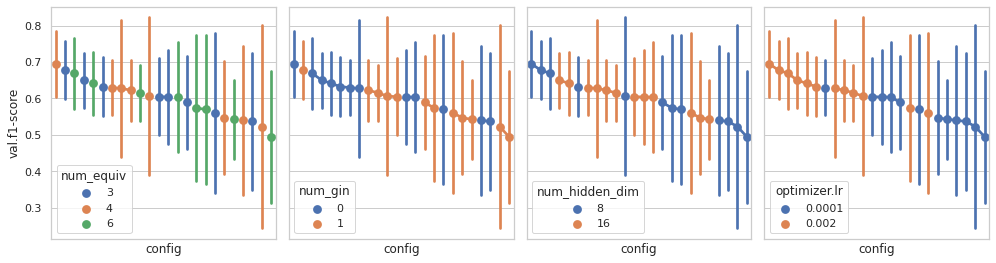

In [22]:
fig, ax = plt.subplots(1, len(hyperparams), figsize=(len(hyperparams) * 3.5, 4), sharex=True, sharey=True)

for param, a in zip(hyperparams, ax):
    sns.pointplot(x='config', y='val.f1-score', data=df, order=config_ordered_f1, ci='sd', hue=param, ax=a)

for a in ax: a.set_xticks([])
for a in ax[1:]: a.set_ylabel('')
plt.suptitle('')
plt.tight_layout()

In [26]:
df[(df.num_equiv == 4) & (df.num_gin == 0) & (df.num_hidden_dim == 8) & (df['optimizer.lr'] == 2e-3)]

,num_equiv,num_gin,num_hidden_dim,optimizer.lr,cv.fold_id,train.accuracy,train.epoch,train.f1-score,train.loss,train.precision,...,train.support,val.accuracy,val.epoch,val.f1-score,val.loss,val.precision,val.recall,val.support,val_loss,config
15,4,0,8,0.002,9,0.411765,1,0.550000,0.697113,0.407407,...,130,0.437500,1,0.608696,0.688453,0.437500,1.000000,7,0.688453,9
39,4,0,8,0.002,8,0.804636,271,0.779026,0.506337,0.759124,...,130,0.777778,271,0.714286,0.459126,0.714286,0.714286,7,0.459126,9
63,4,0,8,0.002,7,0.594771,76,0.581081,0.653951,0.518072,...,130,0.750000,76,0.666667,0.634966,0.800000,0.571429,7,0.634966,9
87,4,0,8,0.002,6,0.750000,277,0.724014,0.556693,0.677852,...,130,0.733333,277,0.750000,0.566366,0.666667,0.857143,7,0.566366,9
111,4,0,8,0.002,5,0.718954,244,0.688406,0.588769,0.650685,...,130,0.687500,244,0.615385,0.620891,0.666667,0.571429,7,0.620891,9
135,4,0,8,0.002,4,0.754967,327,0.717557,0.557790,0.712121,...,130,0.944444,327,0.923077,0.365648,1.000000,0.857143,7,0.365648,9
159,4,0,8,0.002,3,0.611111,120,0.653061,0.620709,0.525822,...,130,0.750000,120,0.750000,0.551882,0.666667,0.857143,7,0.551882,9
183,4,0,8,0.002,2,0.601307,54,0.523438,0.666592,0.531746,...,130,0.687500,54,0.666667,0.624796,0.625000,0.714286,7,0.624796,9
207,4,0,8,0.002,1,0.627517,98,0.621160,0.631474,0.551515,...,128,0.700000,98,0.625000,0.583400,0.625000,0.625000,8,0.583400,9
231,4,0,8,0.002,0,0.741722,160,0.713235,0.548790,0.673611,...,128,0.611111,160,0.631579,0.559985,0.545455,0.750000,8,0.559985,9


In [27]:
df[(df.num_equiv == 3) & (df.num_gin == 1) & (df.num_hidden_dim == 8) & (df['optimizer.lr'] == 2e-3)]

,num_equiv,num_gin,num_hidden_dim,optimizer.lr,cv.fold_id,train.accuracy,train.epoch,train.f1-score,train.loss,train.precision,...,train.support,val.accuracy,val.epoch,val.f1-score,val.loss,val.precision,val.recall,val.support,val_loss,config
19,3,1,8,0.002,9,0.486928,4,0.587927,0.692047,0.446215,...,130,0.437500,4,0.608696,0.695991,0.437500,1.000000,7,0.695991,5
43,3,1,8,0.002,8,0.837748,518,0.815094,0.469122,0.800000,...,130,0.833333,518,0.769231,0.412706,0.833333,0.714286,7,0.412706,5
67,3,1,8,0.002,7,0.542484,114,0.580838,0.661614,0.475490,...,130,0.750000,114,0.750000,0.586984,0.666667,0.857143,7,0.586984,5
91,3,1,8,0.002,6,0.698052,283,0.678201,0.592825,0.616352,...,130,0.866667,283,0.833333,0.534299,1.000000,0.714286,7,0.534299,5
115,3,1,8,0.002,5,0.428105,1,0.597701,0.705688,0.426230,...,130,0.437500,1,0.608696,0.690862,0.437500,1.000000,7,0.690862,5
139,3,1,8,0.002,4,0.609272,110,0.562963,0.671473,0.542857,...,130,0.555556,110,0.600000,0.679112,0.461538,0.857143,7,0.679112,5
163,3,1,8,0.002,3,0.633987,85,0.631579,0.637503,0.551724,...,130,0.625000,85,0.666667,0.594814,0.545455,0.857143,7,0.594814,5
187,3,1,8,0.002,2,0.653595,141,0.558333,0.637181,0.609091,...,130,0.687500,141,0.705882,0.596353,0.600000,0.857143,7,0.596353,5
211,3,1,8,0.002,1,0.651007,343,0.617647,0.624926,0.583333,...,128,0.650000,343,0.631579,0.591993,0.545455,0.750000,8,0.591993,5
235,3,1,8,0.002,0,0.622517,56,0.592857,0.657469,0.546053,...,128,0.555556,56,0.600000,0.583694,0.500000,0.750000,8,0.583694,5
